## TFIM (残留EE, 分割時間, 横磁場, 周期境界条件なし)

\[
H = - J \sum_i S_i^z S_{i+1}^z \;-\; h_x \sum_i S_i^x
\]

In [28]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

In [4]:
# =========
T_total, nt = 3000.0, 600
# T_total, nt = 10.0, 200
tlist = np.linspace(0.0, T_total, nt)
# =========

def simulate(N, J, hx, T_cut):
    cut_pos = N // 2 - 1
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sy = [op_at(i, sy) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return (Sz[i] * Sz[i+1])

    def H_trans(i):
        return Sx[i]

    H_cut_unit = H_exchange(cut_pos)
    H_exchange_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    H_trans_unit = sum(H_trans(i) for i in range(N))
    H_full = -J * (H_exchange_unit + H_cut_unit) - hx * H_trans_unit

    H_static = -J * (H_exchange_unit) - hx * H_trans_unit
    left_sides = list(range(N//2))
    solver_opts = dict(store_states=False, progress_bar =None, rtol = 1e-6, atol=1e-8, nsteps=20000)


    def ramp(t, T_cut):
        if T_cut <= 0.0:
            return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0:
            return 1.0
        if t >= T_cut:
            return 0.0
        return 1.0 - t / T_cut

    def coeff(t, T_cut, J, args=None):
        return - J * ramp(t, T_cut)

    def make_H_time(T_cut: float, J: float):
        return [H_static, [ - J * H_cut_unit, lambda t, args: ramp(t, T_cut)]]

    def EE_op(t, state, args=None):
        rhoL = qt.ptrace(state, left_sides)
        return float(qt.entropy_vn(rhoL, base=2))

    def run_resi_EE_curve(T_cut: float, J: float, psi0):
        H_time = make_H_time(T_cut, J)
        sol = qt.sesolve(H_time, psi0, tlist, e_ops=[EE_op], options=solver_opts)
        # 最後の値のみとってきている
        return np.array(sol.expect[0])[-1]


    _, psi_ground = H_full.groundstate(sparse=True)
    return run_resi_EE_curve(T_cut, J, psi_ground)

N is 4
N is 6
N is 8
N is 10


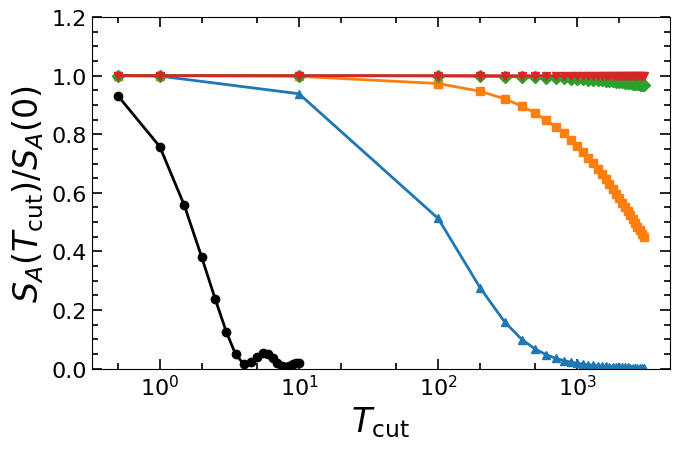

In [29]:
# 軽量ユーティリティ
def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True,
                   length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

def load_series(path: Path):
    """2列: T_cut, S_A を読み込む。csv/tsv/空白区切り＆ヘッダありも許容。"""
    try:
        arr = np.genfromtxt(path, delimiter=",", dtype=float)
        if np.isnan(arr).any():  # うまく読めない/ヘッダありのとき
            arr = np.genfromtxt(path, delimiter=",", dtype=float, comments="#", skip_header=1)
    except Exception:
        try:
            arr = np.genfromtxt(path, delimiter="\t", dtype=float)
            if np.isnan(arr).any():
                arr = np.genfromtxt(path, delimiter="\t", dtype=float, comments="#", skip_header=1)
        except Exception:
            arr = np.genfromtxt(path, dtype=float)
            if np.isnan(arr).any():
                arr = np.genfromtxt(path, dtype=float, comments="#", skip_header=1)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 2)
    x, y = arr[:, 0].astype(float), arr[:, 1].astype(float)
    return x, y


# 見た目の最小調整
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "lines.linewidth": 2.0,
    "axes.titlesize": 16,
})

# ==== パラメータ ====
hx = 0.2
N_list = [4, 6, 8, 10]
SQUARE_FILE = Path("../data/finalEE_J1_square.csv")

# ==== プロット枠 ====
fig, ax = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax)

# ==== 参照データ（正方格子） ====
if SQUARE_FILE.exists():
    x_sq, y_sq = load_series(SQUARE_FILE)
    y0 = y_sq[0]
    y_sq_norm = y_sq / y0
    pos = x_sq > 0.0
    ax.plot(x_sq[pos], y_sq_norm[pos], marker='o', color='black',
            markersize=6.0)
else:
    print("Square data not found:", SQUARE_FILE)

# ==== TFIM（シミュレーション） ====
markers = ['^', 's', 'D', 'v']
for i, N in enumerate(N_list):
    print(f"N is {N}")
    T_cut_list = np.linspace(0.0, 3000.0, 31)
    T_extra = np.array([0.5, 1.0, 10.0])
    T_all = np.unique(np.r_[T_cut_list, T_extra])

    J = 1.0
    SA_all = np.empty(T_all.size, dtype=float)
    for j, t in enumerate(T_all):
        SA_all[j] = float(simulate(N=N, J=J, hx=hx, T_cut=t))

    # 正規化（T_cut=0の点を基準）
    zero_idx = np.where(np.isclose(T_all, 0.0))[0]
    if zero_idx.size == 0:
        raise ValueError("T_all に 0.0 が含まれていません（正規化できません）")
    y_all = SA_all / SA_all[zero_idx[0]]

    pos = T_all > 0.0
    ax.plot(T_all[pos], y_all[pos],
            marker=markers[i % len(markers)], markersize=6.0, label=f"N={N}")

# ==== 軸と保存 ====
ax.set_xscale('log')
ax.set_xlabel(r"$T_{\rm cut}$", fontsize=24)
ax.set_ylabel(r"$S_A(T_{\rm cut})/S_A(0)$", fontsize=24)
ax.set_ylim(0.0, 1.2)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=[2, 5]))
ax.xaxis.set_major_formatter(LogFormatterSciNotation())
fig.tight_layout()

OUTDIR = Path("../charts/TFIM"); OUTDIR.mkdir(parents=True, exist_ok=True)
# nstamp = '-'.join(map(str, N_list))
fig.savefig(OUTDIR / f"resiSA_vs_Tcut_hx_{hx}_N_{nstamp}_square_compare.pdf", bbox_inches="tight", dpi=300)

plt.show()
